In [1]:
import numpy
import geopandas
import pandas
import pulp
from shapely.geometry import Point
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


该问题由 4 个数据文件组成 - network_distance 是由 ArcGIS Network Analyst Extension 计算的设施候选站点之间距离的计算 - demand_points 表示具有设施位置问题（如人口）的一些重要特征的请求点 - facility_points 表示作为候选设施的商店地点 - 区域是人口普查区域 205 的多边形。

In [2]:
DIRPATH = "../0713update/data/"

network_distance = pandas.read_csv(DIRPATH+"SF_network_distance_candidateStore_16_censusTract_205_new.csv")
demand_points = pandas.read_csv(DIRPATH+ "SF_demand_205_centroid_uniform_weight.csv", index_col=0)
facility_points = pandas.read_csv(DIRPATH + "SF_store_site_16_longlat.csv", index_col=0)
study_area = geopandas.read_file(DIRPATH + "ServiceAreas_4.shp").dissolve()

In [3]:
network_distance.head(5)

,distance,name,DestinationName,demand
0,671.573346,Store_1,60750479.01,6540
1,1333.708063,Store_1,60750479.02,3539
2,1656.188884,Store_1,60750352.02,4436
3,1783.006047,Store_1,60750602.00,231
4,1790.950612,Store_1,60750478.00,7787


In [4]:
display(demand_points)

,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat
1,1,6081602900,60816029.00,California,0.48627,4135,1679,1715,112,-122.488653,37.650807
2,2,6081602800,60816028.00,California,0.47478,4831,1484,1506,59,-122.483550,37.659998
3,3,6081601700,60816017.00,California,0.46393,4155,1294,1313,55,-122.456484,37.663272
4,4,6081601900,60816019.00,California,0.81907,9041,3273,3330,118,-122.434247,37.662385
5,5,6081602500,60816025.00,California,0.46603,5146,1459,1467,44,-122.451187,37.640219
...,...,...,...,...,...,...,...,...,...,...,...
201,204,6075011100,60750111.00,California,0.09466,5559,2930,3037,362,-122.418479,37.791082
202,205,6075012200,60750122.00,California,0.07211,7035,3862,4074,272,-122.417237,37.785728
203,206,6075017601,60750176.01,California,0.24306,5756,2437,2556,943,-122.410115,37.779459
204,207,6075017800,60750178.00,California,0.27882,5829,3115,3231,807,-122.405411,37.778934


In [5]:
facility_points.head(5)

,OBJECTID,NAME,long,lat
1,1,Store_1,-122.510018,37.772364
2,2,Store_2,-122.488873,37.753764
3,3,Store_3,-122.464927,37.774727
4,4,Store_4,-122.473945,37.743164
5,5,Store_5,-122.449291,37.731545


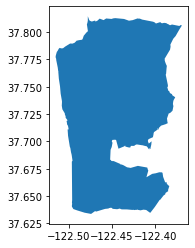

In [6]:
study_area.plot()

要开始假设 期望的参数对问题进行建模spopt.locate，我们应该传递一个 numpy 二维数组作为 cost_matrix。因此，首先我们旋转 network_distance 数据帧。
请注意，列和行是按字母顺序排列的。

In [7]:
ntw_dist_piv = network_distance.pivot_table(values="distance", index="DestinationName", columns="name")
ntw_dist_piv

name,Store_1,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7
DestinationName,,,,,,,,,,,,,,,,
60750101.0,11495.190454,20022.666503,10654.593733,8232.543149,7561.399789,4139.772198,4805.805279,2055.530234,225.609240,1757.623456,11522.519829,7529.985950,10847.234951,10604.729605,20970.277793,15242.989416
60750102.0,10436.169910,19392.094770,10024.022001,7601.971416,6930.828057,3093.851654,4175.233547,1257.809690,1041.911304,2333.244000,10509.099285,6470.965406,10216.663219,9974.157873,20339.706061,14612.417684
60750103.0,10746.296811,19404.672860,10036.600090,7614.549505,6943.406146,3381.778555,4187.811636,2046.436590,744.584403,1685.517099,10800.926186,6778.892307,10229.241308,9986.735962,20352.284150,14624.995773
60750104.0,11420.492134,19808.368182,10440.295413,8018.244828,7347.101469,4044.473877,4591.506959,2463.736278,795.715285,1282.217412,11308.221508,7447.187630,10632.936630,10390.431285,20755.979472,15028.691095
60750105.0,11379.443952,19583.920000,10215.847231,7793.796646,7122.653287,4103.725695,4367.058776,3320.283731,1731.462738,249.669959,11083.773326,7379.539448,10408.488448,10165.983103,20531.531290,14804.242913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60816025.0,17324.066610,2722.031291,10884.063331,14178.007937,13891.857275,18418.384867,16726.951785,20834.395022,21441.247824,20875.680521,14662.484617,16569.371114,12483.322114,11926.727459,4968.842581,8648.054204
60816026.0,15981.172325,3647.137006,10299.369046,13593.313651,13307.162990,17833.690581,16142.257500,20249.700736,20856.553539,20290.986235,14050.290332,15963.776829,11871.527828,11342.033174,3625.948296,7919.659919
60816027.0,14835.342712,4581.333336,9637.139433,12931.084039,12644.933377,17171.460969,15480.027887,19587.471124,20194.323926,19628.756623,13341.313338,15301.547216,11209.298215,10679.803561,2290.818683,7242.830306


在这里，数据透视表被转换为 numpy 二维数组，如spopt.locate预期的那样。矩阵的形状为 205x16。

In [8]:
cost_matrix = ntw_dist_piv.to_numpy()
cost_matrix

array([[11495.19045438, 20022.66650296, 10654.59373325, ...,
        10604.72960533, 20970.27779306, 15242.98941606],
       [10436.16991032, 19392.09477041, 10024.0220007 , ...,
         9974.15787278, 20339.70606051, 14612.41768351],
       [10746.29681106, 19404.67285964, 10036.60008993, ...,
         9986.73596201, 20352.28414974, 14624.99577275],
       ...,
       [14835.34271218,  4581.3333364 ,  9637.13943331, ...,
        10679.80356124,  2290.81868301,  7242.83030602],
       [13339.49169134,  6392.85637207,  8577.48841247, ...,
         9620.15254039,  1846.79564734,  5746.97928517],
       [15257.85568393,  6394.92036466, 10253.75240505, ...,
        11296.41653298,   508.93165475,  7665.34327776]])

In [9]:
cost_matrix[0,1]
# destination1和store11，第二个取服务点

20022.666502961507

## 用Gurobi应用到本实例

In [10]:
# 设置参数
num_facilities=len(facility_points)
num_demand_points=len(demand_points)

num_facilities

16

In [11]:
num_demand_points

205

In [12]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model('facility_location')
# 添加决策变量
select = m.addVars(num_facilities, vtype=GRB.BINARY, name='Select')
# 设置限制条件
    # 每个i在距离x(5000)内至少被1个j覆盖
m.addConstrs((gp.quicksum(select[j] for j in range(num_facilities) if cost_matrix[i,j] < 5000) >= 1  for i in range(num_demand_points)), name='Demand')
# 设置模型目标
m.setObjective(gp.quicksum(select[j] for j in range(num_facilities)), GRB.MINIMIZE)
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 205 rows, 16 columns and 907 nonzeros
Model fingerprint: 0x3069faf2
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 8.0000000
Presolve removed 205 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%


In [13]:
select

{0: <gurobi.Var Select[0] (value 0.0)>,
 1: <gurobi.Var Select[1] (value 1.0)>,
 2: <gurobi.Var Select[2] (value 1.0)>,
 3: <gurobi.Var Select[3] (value -0.0)>,
 4: <gurobi.Var Select[4] (value 1.0)>,
 5: <gurobi.Var Select[5] (value 0.0)>,
 6: <gurobi.Var Select[6] (value 1.0)>,
 7: <gurobi.Var Select[7] (value -0.0)>,
 8: <gurobi.Var Select[8] (value 0.0)>,
 9: <gurobi.Var Select[9] (value 0.0)>,
 10: <gurobi.Var Select[10] (value 1.0)>,
 11: <gurobi.Var Select[11] (value 1.0)>,
 12: <gurobi.Var Select[12] (value 0.0)>,
 13: <gurobi.Var Select[13] (value 0.0)>,
 14: <gurobi.Var Select[14] (value 1.0)>,
 15: <gurobi.Var Select[15] (value 1.0)>}

取了cost_matrix中的第2、3、5、7、11、12、15、16个
也即store 11 12 14 16 2 3 6 7
与pulp调用的结果相同

## 手动多重解

In [14]:
# Limit how many solutions to collect 想要收集多少个解
m.setParam(GRB.Param.PoolSolutions, 10)

# Limit the search space by setting a gap for the worst possible solution that will be accepted
m.setParam(GRB.Param.PoolGap, 0)

# do a systematic search for the k-best solutions
m.setParam(GRB.Param.PoolSearchMode, 2)

Set parameter PoolGap to value 0
Set parameter PoolSearchMode to value 2


In [15]:
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 205 rows, 16 columns and 907 nonzeros
Model fingerprint: 0x3069faf2
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Loaded MIP start from previous solve with objective 8

Presolve removed 199 rows and 5 columns
Presolve time: 0.00s
Presolved: 6 rows, 11 columns, 19 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)

Root relaxation: objective 8.000000e+00, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0         8.00000    8.00000  0.00%     -    0s

Optimal solution found at node 0 

In [16]:
nSolutions = m.SolCount
print(nSolutions)

8


依次查看每个solution的选点情况

发现设施总数的最小值是8个

In [17]:
m.setParam(GRB.Param.SolutionNumber, 0)

print('Selected elements in first best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in first best solution:
	 1 2 4 9 11 12 14 15


In [18]:
m.setParam(GRB.Param.SolutionNumber, 1)

print('Selected elements in second best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in second best solution:
	 1 2 4 6 10 11 14 15


In [19]:
m.setParam(GRB.Param.SolutionNumber, 2)

print('Selected elements in third best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in third best solution:
	 1 2 4 5 10 11 14 15


In [20]:
m.setParam(GRB.Param.SolutionNumber, 3)

print('Selected elements in fourth best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in fourth best solution:
	 1 2 4 8 10 11 14 15


In [21]:
m.setParam(GRB.Param.SolutionNumber, 4)

print('Selected elements in fifth best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in fifth best solution:
	 1 2 4 9 10 11 14 15


In [22]:
m.setParam(GRB.Param.SolutionNumber, 5)

print('Selected elements in sixth best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in sixth best solution:
	 1 2 4 5 11 12 14 15


In [23]:
m.setParam(GRB.Param.SolutionNumber, 6)

print('Selected elements in seventh best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in seventh best solution:
	 1 2 4 6 11 12 14 15


In [24]:
m.setParam(GRB.Param.SolutionNumber, 7)

print('Selected elements in eighth best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in eighth best solution:
	 1 2 4 8 11 12 14 15


## Extended-LSCP

In [25]:
m_extended = gp.Model('facility_location_extended')
# 添加决策变量
select_extended = m_extended.addVars(num_facilities, vtype=GRB.BINARY, name='Select_extended')
# 设置限制条件
    # 每个i在距离x(5000)内至少被1个j覆盖
m_extended.addConstrs((gp.quicksum(select_extended[j] for j in range(num_facilities) if cost_matrix[i,j] < 5000) >= 1  for i in range(num_demand_points)), name='Demand_extended')

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [26]:
weight = {}
for n in range(8):
    weight[n] = 99
for n in range(8, num_facilities):
    weight[n] = 100

In [27]:
m_extended.setParam(GRB.Param.PoolSolutions, 10)
m_extended.setParam(GRB.Param.PoolGap, 0)
m_extended.setParam(GRB.Param.PoolSearchMode, 2)

Set parameter PoolGap to value 0
Set parameter PoolSearchMode to value 2


In [28]:
# 设置模型目标
m_extended.setObjective(gp.quicksum(select_extended[j] * weight[j] for j in range(num_facilities)), GRB.MINIMIZE)
#m_extended.setObjective(gp.quicksum(99 * select_extended[j] for j in range(8)) + gp.quicksum(100 * select_extended[j] for j in range(8, num_facilities)), GRB.MINIMIZE)
m_extended.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 205 rows, 16 columns and 907 nonzeros
Model fingerprint: 0x168a96c3
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 797.0000000
Presolve removed 199 rows and 5 columns
Presolve time: 0.00s
Presolved: 6 rows, 11 columns, 19 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)
Found heuristic solution: objective 796.0000000

Root relaxation: objective 7.960000e+02, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0       796.00000  796.00000  0.00%     - 

In [29]:
nSolutions_extended = m_extended.SolCount
print(nSolutions_extended)

4


再次查看4个solution的选点情况  
  
检查：  
1）是否在刚才手动8个解中  
2）是否满足extended模型，现存设施最多的条件（本例中假设，现存设施为j的序号小于8的设施）  

In [30]:
m_extended.setParam(GRB.Param.SolutionNumber, 0)

print('Selected elements in first best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select_extended[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in first best solution:
	 1 2 4 5 11 12 14 15


为手动中的第6个解，现存设施有4个

In [31]:
m_extended.setParam(GRB.Param.SolutionNumber, 1)

print('Selected elements in second best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select_extended[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in second best solution:
	 1 2 4 6 11 12 14 15


为手动中的第7个解，现存设施有4个

In [32]:
m_extended.setParam(GRB.Param.SolutionNumber, 2)

print('Selected elements in third best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select_extended[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in third best solution:
	 1 2 4 5 10 11 14 15


为手动中的第3个解，现存设施有4个

In [33]:
m_extended.setParam(GRB.Param.SolutionNumber, 3)

print('Selected elements in third best solution:')
print('\t', end='')
for j in range(num_facilities):
    if select_extended[j].Xn >= 1:
        print(' %d' % j, end='')
print('')

Selected elements in third best solution:
	 1 2 4 6 10 11 14 15


为手动中的第2个解，现存设施有4个

再检查手动模型中剩下的4个解，是否不符合extended最优的要求：  
其他4个解的现存设施数为3个，确实不符合extended要求  
  

由此简单例子，extended模型的代码应该是正确的。

再验证一下我写的关于计算现存和潜在设施点数的代码是否正确：

In [37]:
# Print objective values of solutions
for e in range(4):
    m_extended.setParam(GRB.Param.SolutionNumber, e)
    print('%g ' % m_extended.PoolObjVal, end='')
    if e % 15 == 14:
        print('')
print('')

796 796 796 796 


In [34]:
summary_extended = pandas.DataFrame(columns=['existing_count', 'potential_count'], index=range(4))

In [35]:
for n in range(4):
    m_extended.setParam(GRB.Param.SolutionNumber, n)
    
    #一共8个existing facilities；计算序号小于等于7的有多少个
    sum = 0
    for j in range(8):
        if select_extended[j].Xn >= 1.0:
            sum = sum + 1
    summary_extended.iloc[n,0] = sum

    #计算potential sites数量
    sum_potential = 0
    for j in range(8, num_facilities):
        if select_extended[j].Xn >= 1.0:
            sum_potential = sum_potential + 1
    summary_extended.iloc[n,1] = sum_potential

In [36]:
summary_extended

,existing_count,potential_count
0,4,4
1,4,4
2,4,4
3,4,4


796 = 4 * 99 + 4 * 100  
  
能证实上述代码在本例中是没有问题的